In [23]:
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt


In [17]:
import os
import pydicom
import numpy as np
from collections import defaultdict

def load_series(modality_path):
    """
    Load all DICOM files in the modality folder, group them by series,
    sort each series by InstanceNumber (if available), and stack the slices
    into a 3D volume.
    
    Parameters:
        modality_path (str): Path to the modality directory (e.g., CTAC_DICOM)
    
    Returns:
        dict: A dictionary mapping each SeriesInstanceUID to its 3D NumPy volume.
    """
    series_dict = defaultdict(list)
    
    # Loop through all files in the modality directory.
    for file in os.listdir(modality_path):
        file_path = os.path.join(modality_path, file)
        # Skip hidden files and ensure the file is not a directory.
        if os.path.isfile(file_path) and not file.startswith('.'):
            try:
                ds = pydicom.dcmread(file_path)
                # Use SeriesInstanceUID to group slices. If not available, use a default key.
                series_id = ds.get("SeriesInstanceUID", "UnknownSeries")
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    # Process each series: sort the slices and stack them into a 3D array.
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        # Sort slices; if InstanceNumber is not available, you might consider using SliceLocation.
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = volume
        except Exception as e:
            print(f"Error stacking slices for series {series_id}: {e}")
    
    return series_volumes

def load_patient_data(patient_folder):
    """
    Traverse a patient's folder containing multiple studies. For each study,
    load the two modalities (CTAC_DICOM and QClear 550_DICOM) and process
    each modality by grouping files into series.
    
    Parameters:
        patient_folder (str): Path to the patient folder.
        
    Returns:
        dict: Nested dictionary with structure:
              {study_name: {modality_name: {series_id: volume}}}
    """
    patient_data = {}
    
    # Loop through each study in the patient folder.
    for study_name in os.listdir(patient_folder):
        study_path = os.path.join(patient_folder, study_name)
        if os.path.isdir(study_path):
            patient_data[study_name] = {}
            # Define the expected modalities
            for modality in ['CTAC_DICOM', 'QClear 550_DICOM']:
                modality_path = os.path.join(study_path, modality)
                if os.path.exists(modality_path) and os.path.isdir(modality_path):
                    print(f"Loading modality: {modality_path}")
                    series_volumes = load_series(modality_path)
                    patient_data[study_name][modality] = series_volumes
                else:
                    print(f"Modality folder not found: {modality_path}")
    
    return patient_data

# Example usage:
# Replace the path below with the path to your patient folder.
patient_folder = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105"

data = load_patient_data(patient_folder)

# Display the loaded data structure
for study, modalities in data.items():
    print(f"Study: {study}")
    for modality, series_dict in modalities.items():
        print(f"  Modality: {modality}")
        for series_id, volume in series_dict.items():
            print(f"    Series: {series_id} with volume shape: {volume.shape}")


Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00001\CTAC_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00001\QClear 550_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00002\CTAC_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00002\QClear 550_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00003\CTAC_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\00000105\LOD LST 00003\QClear 550_DICOM
Loading modality: C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure



In [20]:
def visualize_volume_3d(volume, level=None):
    """
    Visualize a 3D volume using isosurface extraction via the marching cubes algorithm.
    
    Parameters:
        volume (ndarray): 3D NumPy array representing the image volume.
        level (float): The intensity threshold for isosurface extraction.
                       If None, the mean value of the volume is used.
    """
    if level is None:
        level = np.mean(volume)
        print(f"No level provided. Using mean intensity: {level:.2f}")
    
    # Extract isosurface using the marching cubes algorithm.
    verts, faces, normals, values = measure.marching_cubes(volume, level=level)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a mesh from the extracted surface
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    # Set plot limits based on volume dimensions
    ax.set_xlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[2])
    ax.set_title("3D Volume Rendering")
    
    plt.tight_layout()
    plt.show()


In [21]:
def visualize_slice(volume, slice_index=None, axis=0):
    """
    Visualize a 2D slice from a 3D volume.
    
    Parameters:
        volume (ndarray): 3D NumPy array representing the image volume.
        slice_index (int): Index of the slice to display. If None, the middle slice is used.
        axis (int): Axis along which to take the slice (0, 1, or 2).
    """
    # Determine default slice index (middle slice) if not provided.
    if slice_index is None:
        slice_index = volume.shape[axis] // 2

    # Extract the 2D slice based on the selected axis.
    if axis == 0:
        slice_data = volume[slice_index, :, :]
    elif axis == 1:
        slice_data = volume[:, slice_index, :]
    elif axis == 2:
        slice_data = volume[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2.")
    
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"2D Slice (axis={axis}, index={slice_index})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


No level provided. Using mean intensity: 624.45


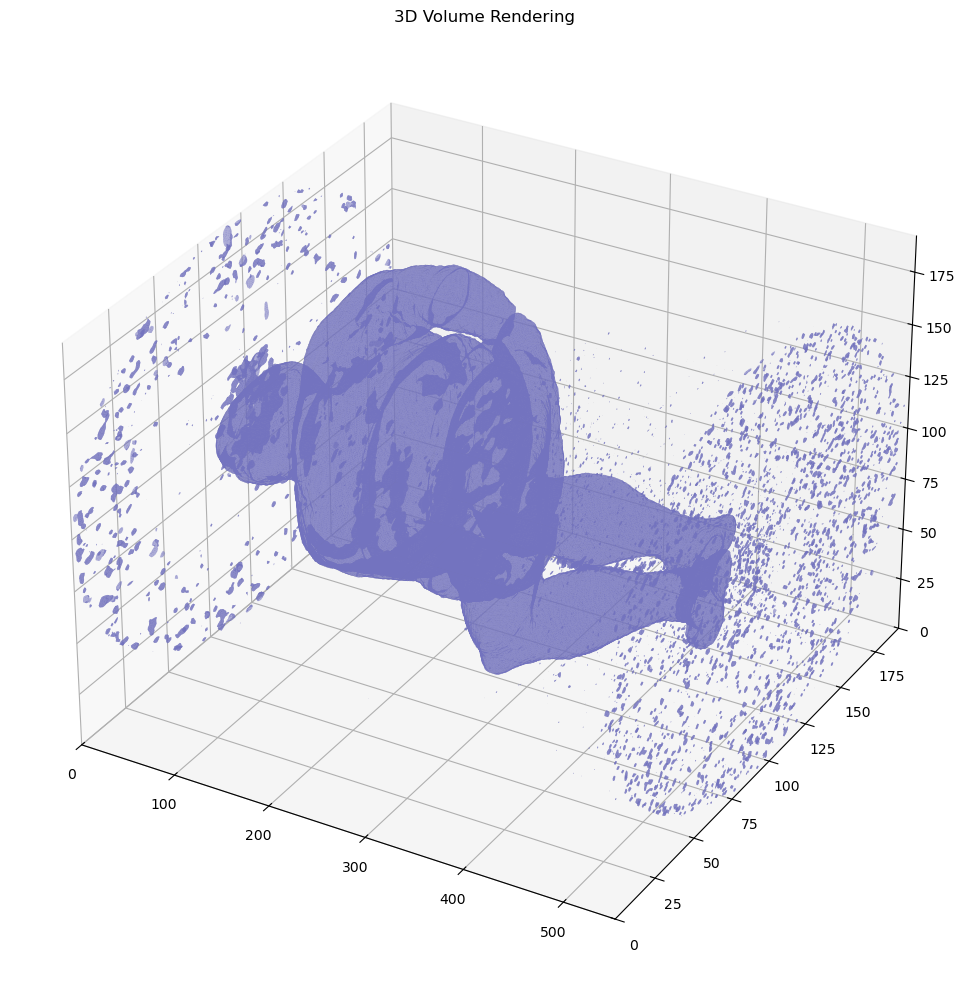

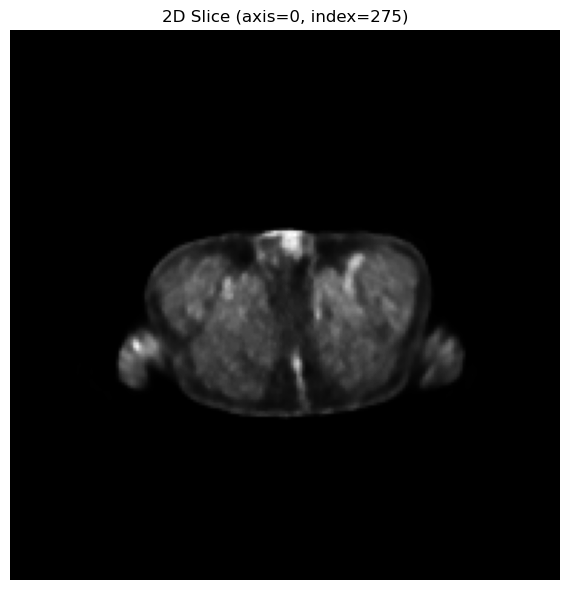

In [22]:
# Example: Visualize the 3D volume.
visualize_volume_3d(volume, level=None)  # You can set level manually if desired, e.g., level=100

# Example: Visualize a 2D slice (middle slice along the first dimension).
visualize_slice(volume, axis=0)


In [ ]:
import pydicom
import numpy as np
import math
import datetime

def parse_dicom_time(time_str):
    """
    Parses a DICOM time string which may be in HHMMSS or HHMMSS.FFFFFF format.
    """
    if '.' in time_str:
        return datetime.datetime.strptime(time_str, "%H%M%S.%f")
    else:
        return datetime.datetime.strptime(time_str, "%H%M%S")

def calculate_decay_correction_factor(series_time, start_time, half_life):
    """
    Calculate the decay correction factor based on the time difference.
    
    Parameters:
      series_time (datetime): Time when the series was acquired.
      start_time (datetime): Time when the radiopharmaceutical was administered.
      half_life (float): Radionuclide half-life (in seconds).
      
    Returns:
      float: Decay correction factor.
    """
    # Calculate time difference in seconds
    delta_t = (series_time - start_time).total_seconds()
    # Decay correction factor: exp(-ln2 * delta_t / half_life)
    return math.exp(-math.log(2) * delta_t / half_life)

def convert_to_suv(pixel_array, ds):
    """
    Convert raw PET image pixel data to SUV values using the DICOM metadata.
    
    Required metadata:
      - RescaleSlope
      - RescaleIntercept
      - RadiopharmaceuticalTotalDose (in Bq)
      - RadionuclideHalfLife (in seconds)
      - RadiopharmaceuticalStartTime (as a string HHMMSS or HHMMSS.FFFFFF)
      - SeriesTime (as a string HHMMSS or HHMMSS.FFFFFF)
      - PatientWeight (in grams; if in kg, multiply by 1000)
    
    Parameters:
      pixel_array (np.ndarray): The raw PET image data.
      ds (pydicom.Dataset): A DICOM dataset (from which metadata is read).
    
    Returns:
      np.ndarray: The PET image converted to SUV values.
    """
    # Extract metadata (with defaults in case a field is missing)
    rescale_slope = float(ds.get("RescaleSlope", 1))
    rescale_intercept = float(ds.get("RescaleIntercept", 0))
    total_dose = float(ds.get("RadiopharmaceuticalTotalDose", 1))
    half_life = float(ds.get("RadionuclideHalfLife", 1))
    
    # These fields are typically stored as strings
    start_time_str = ds.get("RadiopharmaceuticalStartTime", "000000")
    series_time_str = ds.get("SeriesTime", "000000")
    
    patient_weight = float(ds.get("PatientWeight", 1))
    # If weight is in kg instead of grams, uncomment the following line:
    # patient_weight *= 1000
    
    # Parse the time strings into datetime objects
    start_time = parse_dicom_time(start_time_str)
    series_time = parse_dicom_time(series_time_str)
    
    # Compute the decay correction factor
    decay_factor = calculate_decay_correction_factor(series_time, start_time, half_life)
    
    # Convert raw pixel values to activity concentration in Bq/ml
    activity_concentration = pixel_array * rescale_slope + rescale_intercept
    
    # Adjust the total dose to the series time using decay correction
    corrected_dose = total_dose * decay_factor
    
    # Compute SUV: (activity concentration [Bq/ml] * patient weight [g]) / (corrected dose [Bq])
    suv_image = (activity_concentration * patient_weight) / corrected_dose
    
    return suv_image

# Example usage:
# Assume you have loaded one DICOM file from a PET series.
# Replace the file path with your actual DICOM file path.
dicom_path = r"C:\path\to\your\PET_DICOM_file.dcm"
ds = pydicom.dcmread(dicom_path)
pixel_array = ds.pixel_array

# Convert to SUV
suv_image = convert_to_suv(pixel_array, ds)

# Now, suv_image contains the SUV values which you can further process (e.g., discretization, clipping, or MIP generation).
print("SUV image shape:", suv_image.shape)
